<h1 style="color:#54a7b5">3D Computer Vision (WS25/26) - Project</h1>

<h2 style="color:#007b90">General Information</h2>

Upload: 29.10.2025

**Intermediate Deadline**: 27.11.2025 (Step 1-2)

**Final Deadline**: 23.01.2026 (Step 1-5)

<h3 style="color:#003476">Your Group</h3>

Submitted by Group XX: 
- Name1
- Name2
- Name3
- Name4

<h3 style="color:#003476">Submission</h3>

Please hand in a single **.zip** file named according to the pattern "**groupXX**" (e.g. group00). The contents of the .zip should be as follows:
- folder with the same name as the **.zip** file
    - **.ipynb** file
    - **.html** export of .ipynb with all the outputs you got
    - **data** folder containing necessary files to run the code

By submitting this exercise, you confirm the following:
- **All people** listed above **contributed** to this solution
- **No other people** were **involved** in this solution
- **No contents** of this solution were **copied from others** (this includes people, large language models, websites, etc.)

<h3 style="color:#003476">Final Presentation</h3>

You will be required to present your solution in a 20 minute presentation, which includes:
- Problem Overview
- Solution Overview (e.g. pseudo code, mathematical formulas, visualizations)
- Describe challenges & optimizations

After the presentation, there will be 10 minutes of questions and answers about your work.


<h2 style="color:#007b90">3D Scene Reconstruction - Task Overview</h2>

Your task in this exercise is to do a dense reconstruction of a scene. This will involve multiple steps that you will encounter and learn about as the semester progresses. You can start implementing individual steps as soon as you learn about them or wait until you have learned more to implement everything together. In the latter case, be mindful that this exercise is designed for an entire semester and the workload is accordingly large.

<h3 style="color:#003476">Given Data</h3>

You will be given the following data:
- **9 color images** of the scene.
    - 8 Bit RGB per pixel.
    - Each image rendered from a different position.
    - The camera used had **lens distortion**.
- **9 Depth images** of the scene.
    - 8 Bit Grayscale per pixel. The result of dividing the Z-depth by **each image's maximum** and then multiplying by 255.
    - Each image has the **same pose** as the corresponding RGB image.
    - The camera used was **free of any distortions**.
- 1 Dictionary containing **camera calibration parameters**.
    - They belong to the camera that was used to render the RGB images.
    - Distortion coefficients are given in the standard [k<sub>1</sub>, k<sub>2</sub>, p<sub>1</sub>, p<sub>2</sub>, k<sub>3</sub>] order.
- 1 Numpy array containing **8 camera transformations**.
    - They specify the **movements** that the **camera went through** to render all images.
    - I.e. idx **0** specifies the transformation from **00.png to 01.png**, idx **1** specifies the transformation from **01.png to 02.png**, ...
    - This applies to both RGB and Depth images, as they have the same poses.
- 1 Numpy array containing **7 features**.
    - The features are specified for each of the 9 images.
    - Each feature is a **2D pixel location in "H, W" order**, meaning the first value is the height/row in the image and the second width/column.
    - If a feature was not visible, it was entered as [-1, -1].
    - The features are **unsorted**, meaning that feature idx 0 for 00.png could be corresponding to e.g. feature idx 4 for 01.png.

<h3 style="color:#003476">Solution Requirements</h3>

- Your code needs to **compile**, **run**, and produce an **output**.
- Your target output should be a **dense point cloud** reconstruction (without holes) of the scene.
    - The output should be in the **.ply format**. We provide a function that can exports a .ply file.
    - You may inspect your .ply outputs in e.g. **Meshlab**.
    - See the 'Dense Point Cloud' sample image to get an idea of what is possible. (Meshlab screenshot with point shading set to None; see example under data/samples)
- Your code should be a **general solution**.
    - This means that it could run correctly for a different dataset (with same input structure).
    - It should **NOT** include anything **hardcoded** specific to this dataset.
- Your code should not be unnecessarily inefficient.
    - Our sample solution runs in less than 2 minutes total (including point cloud export).
    - If your solution runs for more than 10 minutes, you are being wasteful in some part of your program.

<h2 style="color:#007b90">Imports</h2>

Please note the following:
- These are all imports necessary to achieve the sample results.
- You may remove and/or add other libraries at your own convinience.
- Using library functions (from the given or other libraries) that bypass **necessary computer vision tasks** will not be recognized as 'solved'.
    - E.g.: If you **need** to undistort an image to **get to the next step** of the solution and use the library function cv2.undistort(), then we will evaluate the **undistortion step** as '**failed**'.
    - E.g.: If you **want** to draw points in an image (to **check your method** or **visualize in-between steps**) and use the library function cv2.circle(), then there is **no problem**.
    - E.g.: If you **need** to perform complex **mathematical** operations and use some numpy function, then there is **no problem**.
    - E.g.: You do not like a **provided utility function** and find/know a library function that gives the **same outputs** from the **same inputs**, then there is **no problem**.

In [9]:
import os
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#make plots interactive:
%matplotlib widget
%matplotlib inline

<h2 style="color:#007b90">Data Preparation</h2>

In [10]:
#Inputs
base_path = os.getcwd()
data_path = os.path.join(base_path, f"data")
img_path = os.path.join(data_path, 'images')
depth_path = os.path.join(data_path, 'depths')
print(f"The project's root path is '{base_path}'.")
print(f"Reading data from '{data_path}'.")
print(f"Image folder: '{img_path}'.")
print(f"Depth folder: '{depth_path}'.")

#Outputs
out_path = os.path.join(base_path, 'output')
ply_path = os.path.join(out_path, 'point_cloud')
os.makedirs(out_path, exist_ok=True)
os.makedirs(ply_path, exist_ok=True)
print(f"\nCreating directory '{out_path}'.")
print(f"Creating directory '{ply_path}'.")

#Load Data
camera_calibration = np.load(os.path.join(data_path, 'camera_calibration.npy'), allow_pickle=True)
camera_calibration = camera_calibration.item()#get dictionary from numpy array struct
given_features = np.load(os.path.join(data_path, 'given_features.npy'), allow_pickle=True)
camera_movement = np.load(os.path.join(data_path, 'camera_movement.npy'), allow_pickle=True)

print(f"\nCamera Calibration:")
for entry in camera_calibration.items():
    print(f"  {entry[0]}: {entry[1]}")
print(f"Camera Movement: {camera_movement.shape}")#[Cameras-1, 4, 4]
print(f"2D Features (Unsorted): {given_features.shape}")#[Camera_idx, Feature_idx, 2]

The project's root path is '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13'.
Reading data from '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/data'.
Image folder: '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/data/images'.
Depth folder: '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/data/depths'.

Creating directory '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/output'.
Creating directory '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/output/point_cloud'.

Camera Calibration:
  distortion_param: [-0.1, 0.02, 0.0, 0.0, -0.01]
  image_height: 551
  im

<h2 style="color:#007b90">Provided Utility Functions</h2>

These functions are provided to reduce the complexity of some steps you might encounter. They were involved in the creation of the given samples. However, you do not have to use them and can use other means of achieving the same results.

In [11]:
def sample_image(numpy_image, numpy_sample_grid):
    '''
    This function samples a target image from a source image (numpy_image) based on specified pixel coordinates (numpy_sample_grid).
    Inputs:
        numpy_image: of shape=[H, W, C]. H is the height, W is the width, and C is the color channel of the source image from which color values will be sampled.
        numpy_sample_grid: of shape=[H, W, UV]. H is the height and W is the width of the target image that will be sampled. UV are the pixel locations in the source image from which to sample color values.
    Outputs:
        sampled_image: of shape=[H, W, C]. H is the height, W is the width, and C is the color channel of the target image that was sampled.
    
    The following is a simple toy example to see the behavior of the sample_image function

    example_source = (np.random.rand(110, 220, 3)*255).astype(int) #[110, 220, 3]
    example_grid = np.ones([100, 200, 2]) #[100, 200, 2]
    example_grid[:, :, 1] = 2
    example_target = sample_image(example_source, example_grid) #[100, 200, 3]

    example_target will be of shape [100, 200, 3]
    -> 100, because example_grid has a height of 100
    -> 200, because example_grid has a width of 200
    -> 3, because example_source has a color channel of 3
    print(example_source.shape)

    example_target will contain the value of example_source[2, 1] at every pixel
    -> 2, because example_grid[:, :, 1] has a value of 2 for every pixel
    -> 1, because example_grid[:, :, 0] has a value of 1 for every pixel
    print(example_source[2, 1, 0], "->", np.unique(example_target[:, :, 0]))
    print(example_source[2, 1, 1], "->", np.unique(example_target[:, :, 1]))
    print(example_source[2, 1, 2], "->", np.unique(example_target[:, :, 2]))
    
    '''
    height, width, _ = numpy_image.shape#[H, W, 3]

    #turn numpy array to torch tensor
    torch_sample_grid = torch.from_numpy(numpy_sample_grid)#[H, W, 2]
    #normalize from range (0, width-1) to (0, 1)
    torch_sample_grid[:, :, 0] = torch_sample_grid[:, :, 0] / (width-1)
    #normalize from range (0, height-1) to (0, 1)
    torch_sample_grid[:, :, 1] = torch_sample_grid[:, :, 1] / (height-1)
    #normalize from range (0, 1) to (-1, 1)
    torch_sample_grid = torch_sample_grid*2 -1

    #transform to necessary shapes
    torch_sample_grid = torch_sample_grid.unsqueeze(0)#[1, H, W, 2]
    torch_image = torch.from_numpy(numpy_image).double().permute(2, 0, 1).unsqueeze(0)#[1, 3, H, W]
    #sample image according to sample grid locations from source image
    sampled_image = torch.nn.functional.grid_sample(torch_image, torch_sample_grid, mode='bilinear', padding_mode='zeros', align_corners=True)
    #transform back to numpy image
    sampled_image = sampled_image.squeeze().permute(1, 2, 0).numpy().astype(np.uint8)#[H, W, 3]
    return sampled_image

def ply_creator(input_3d, rgb_data=None, filename='dummy'):
    ''' Creates a colored point cloud that you can visualise using e.g. Meshlab.
    Inputs:
        input_3d: of shape=[N, 3], each row is the 3D coordinate of each point
        rgb_data(optional): of shape=[N, 3], each row is the rgb color value of each point
        filename: file name for the .ply file to be created 
    '''
    assert (input_3d.ndim==2),"Pass 3d points as NumPointsX3 array "
    pre_text1 = """ply\nformat ascii 1.0"""
    pre_text2 = "element vertex "
    pre_text3 = """property float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nend_header"""
    pre_text22 = pre_text2 + str(input_3d.shape[0])
    pre_text11 = pre_text1
    pre_text33 = pre_text3
    filename = filename + '.ply'
    fid = open(filename, 'w')
    fid.write(pre_text11)
    fid.write('\n')
    fid.write(pre_text22)
    fid.write('\n')
    fid.write(pre_text33)
    fid.write('\n')
    for i in range(input_3d.shape[0]):
        for c in range(3):
            fid.write(str(input_3d[i,c]) + ' ')
        if not rgb_data is None:
            for c in range(3):
                fid.write(str(rgb_data[i,c]) + ' ')
        if i!=input_3d.shape[0]:
            fid.write('\n')
    fid.close()
    return filename 

<h2 style="color:#007b90">Step 1: Undistortion of the RGB Images</h2>

As described in the Given Data section, the RGB images contain lens distortion, while the depth images are already undistorted. To ensure accurate 3D reconstruction, the two modalities must be aligned.

Undistort all RGB images, then visualize one example image before and after undistortion.

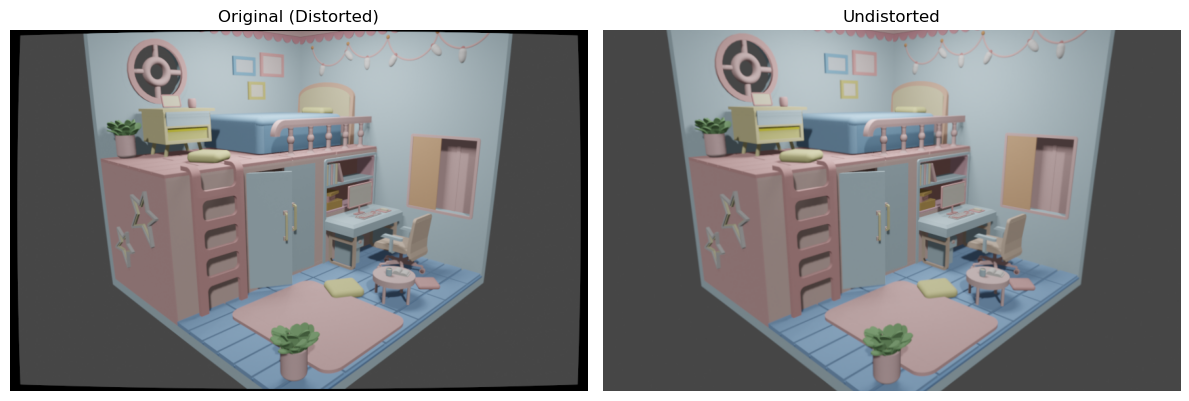

Undistorted 9 images successfully.


In [12]:
# Include the necessary code here
def undistort_images(img_path, camera_calibration):
    """
    Manually undistort all RGB images using camera calibration parameters.
    
    Returns:
        undistorted_images: list of undistorted images
        original_images: list of original distorted images (for comparison)
    """
    # Extract calibration parameters
    fx = camera_calibration['focal_length_px']
    fy = fx * camera_calibration['pixel_ratio']
    cx = camera_calibration['principal_point'][1]  # column (x)
    cy = camera_calibration['principal_point'][0]  # row (y)
    
    # Distortion coefficients [k1, k2, p1, p2, k3]
    k1, k2, p1, p2, k3 = camera_calibration['distortion_param']
    
    h = camera_calibration['image_height']
    w = camera_calibration['image_width']
    
    # Create coordinate grids for the undistorted image
    u, v = np.meshgrid(np.arange(w), np.arange(h))
    
    # Convert pixel coordinates to normalized coordinates
    x_norm = (u - cx) / fx
    y_norm = (v - cy) / fy
    
    # Calculate radius squared
    r2 = x_norm**2 + y_norm**2
    r4 = r2**2
    r6 = r2**3
    
    # Apply radial distortion
    radial_distortion = 1 + k1 * r2 + k2 * r4 + k3 * r6
    
    # Apply tangential distortion
    x_distorted = x_norm * radial_distortion + 2 * p1 * x_norm * y_norm + p2 * (r2 + 2 * x_norm**2)
    y_distorted = y_norm * radial_distortion + p1 * (r2 + 2 * y_norm**2) + 2 * p2 * x_norm * y_norm
    
    # Convert back to pixel coordinates
    u_distorted = x_distorted * fx + cx
    v_distorted = y_distorted * fy + cy
    
    # Create the sampling grid [H, W, 2] where [:,:,0] is u (column) and [:,:,1] is v (row)
    sample_grid = np.stack([u_distorted, v_distorted], axis=-1).astype(np.float64)
    
    # Load and undistort all images
    undistorted_images = []
    original_images = []
    
    for i in range(9):
        img_file = os.path.join(img_path, f'{i:02d}.png')
        img = cv.imread(img_file)
        original_images.append(img)
        
        # Sample from the distorted image at the computed locations
        undistorted = sample_image(img, sample_grid)
        undistorted_images.append(undistorted)
    
    return undistorted_images, original_images

# Run undistortion
undistorted_images, original_images = undistort_images(img_path, camera_calibration)

# Visualize one example (e.g., image 0)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(cv.cvtColor(original_images[0], cv.COLOR_BGR2RGB))
axes[0].set_title('Original (Distorted)')
axes[0].axis('off')

axes[1].imshow(cv.cvtColor(undistorted_images[0], cv.COLOR_BGR2RGB))
axes[1].set_title('Undistorted')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Undistorted {len(undistorted_images)} images successfully.")

Example visualization

![title](data/samples/image_distortion.png)

<h2 style="color:#007b90">Step 2: Common Camera Reference Frame</h2>

The provided camera poses are expressed relative to consecutive frames (e.g. the first pose is a transformation from the first view to the second view). However, the final point cloud needs to be definied with respect to a single, common world coordinate system.

Compute camera poses such that they are expressed in terms of a shared world reference frame, and then visualize all camera positions and orientations in a single 3D plot.


STEP 2: Computing Camera Poses

Sanity check: camera_movement rigidness (det(R)≈1, R^T R≈I)
  step 0: True
  step 1: True
  step 2: True
  step 3: True
  step 4: True
  step 5: True
  step 6: True
  step 7: True

Camera centers in world coordinates:
  Camera 0: [  0.000,   0.000,   0.000]
  Camera 1: [  2.828,  -0.366,   1.366]
  Camera 2: [ -2.828,  -0.366,   1.366]
  Camera 3: [  0.000,   0.966,   0.259]
  Camera 4: [  2.828,   0.600,   1.625]
  Camera 5: [ -2.828,   0.600,   1.625]
  Camera 6: [  0.000,  -0.966,  -0.259]
  Camera 7: [  1.414,  -2.664,   2.214]
  Camera 8: [ -1.414,  -2.664,   2.214]

Camera center spread:
  X span: 5.657
  Y span: 3.630
  Z span: 2.473


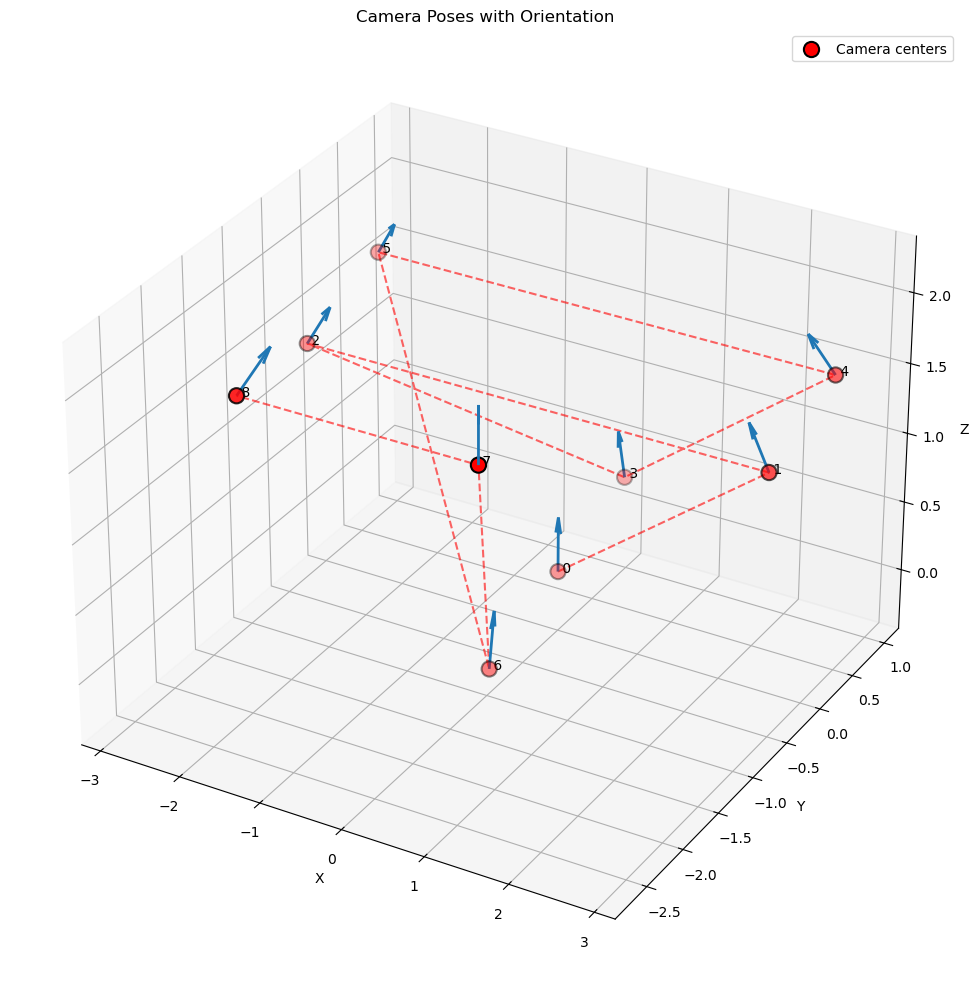

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def invert_rigid_T(T):
    """
    Invert a 4x4 rigid transform T = [R t; 0 1] safely and fast.
    """
    R = T[:3, :3]
    t = T[:3, 3]
    T_inv = np.eye(4)
    T_inv[:3, :3] = R.T
    T_inv[:3, 3] = -R.T @ t
    return T_inv

def is_valid_rigid(T, tol=1e-3):
    """
    Check if T is approximately a rigid transform: R^T R = I and det(R)=+1
    """
    R = T[:3, :3]
    det = np.linalg.det(R)
    ortho_err = np.linalg.norm(R.T @ R - np.eye(3))
    return (abs(det - 1.0) < tol) and (ortho_err < tol)

def compute_world_to_camera_poses(camera_movement, movement_is_i_to_i1=True):
    """
    Compute world-to-camera transformation matrices (T_w2c).

    Parameters
    ----------
    camera_movement : (N-1, 4, 4)
        Relative transforms between consecutive cameras.
        If movement_is_i_to_i1=True:
            camera_movement[i] maps points from camera i -> camera i+1  ( ^c{i+1}T_{c{i}} )
        If movement_is_i_to_i1=False:
            camera_movement[i] maps points from camera i+1 -> camera i ( ^c{i}T_{c{i+1}} )

    movement_is_i_to_i1 : bool
        Set to True if your movement is i -> i+1.
        Set to False if your movement is (i+1) -> i.

    Returns
    -------
    T_world_to_cam : (N, 4, 4)
        T_world_to_cam[i] maps points from world -> camera i.
        Camera 0 is at world origin: T_w2c[0] = I.
    """
    if camera_movement.ndim != 3 or camera_movement.shape[1:] != (4, 4):
        raise ValueError(f"camera_movement must have shape (N-1,4,4). Got {camera_movement.shape}")

    # If movement is reversed, invert EACH transform (not the whole array)
    if not movement_is_i_to_i1:
        camera_movement = np.array([invert_rigid_T(T) for T in camera_movement])

    num_cameras = camera_movement.shape[0] + 1
    T_world_to_cam = np.zeros((num_cameras, 4, 4), dtype=float)

    # Camera 0 defines world frame
    T_world_to_cam[0] = np.eye(4)

    # Chain: T_w2c[i] = ( ^c{i}T_{c{i-1}} ) @ T_w2c[i-1]
    for i in range(1, num_cameras):
        T_world_to_cam[i] = camera_movement[i - 1] @ T_world_to_cam[i - 1]

    return T_world_to_cam

def get_camera_centers(T_world_to_cam):
    """
    Extract camera centers in world coordinates from world->camera transforms.

    For T_w2c = [R | t], camera center C in world coords:
        C = -R^T t
    """
    num_cameras = len(T_world_to_cam)
    camera_centers = np.zeros((num_cameras, 3), dtype=float)

    for i in range(num_cameras):
        R = T_world_to_cam[i][:3, :3]
        t = T_world_to_cam[i][:3, 3]
        camera_centers[i] = -R.T @ t

    return camera_centers

def visualize_camera_setup(camera_centers, T_world_to_cam, arrow_len=0.4):
    """
    Visualize camera positions and orientations in world coordinates.

    Camera forward direction in camera coords (OpenCV): +Z
    World direction: R^T @ [0,0,1] where R is from T_w2c.
    """
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Camera centers
    ax.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2],
               c='red', s=120, edgecolors='black', linewidths=1.5,
               label='Camera centers')

    # Path
    ax.plot(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2],
            'r--', alpha=0.6)

    # Orientation arrows
    for i in range(len(camera_centers)):
        C = camera_centers[i]
        R = T_world_to_cam[i][:3, :3]

        view_dir = R.T @ np.array([0.0, 0.0, 1.0])
        view_dir = view_dir / (np.linalg.norm(view_dir) + 1e-9)  # normalize

        ax.quiver(C[0], C[1], C[2],
                  view_dir[0], view_dir[1], view_dir[2],
                  length=arrow_len, linewidth=2)

        ax.text(C[0], C[1], C[2], f' {i}', fontsize=10)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Camera Poses with Orientation')
    ax.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------
# STEP 2: Computing Camera Poses
# ---------------------------
print("\n" + "=" * 60)
print("STEP 2: Computing Camera Poses")
print("=" * 60)

# --- Optional sanity checks ---
print("\nSanity check: camera_movement rigidness (det(R)≈1, R^T R≈I)")
for k in range(camera_movement.shape[0]):
    ok = is_valid_rigid(camera_movement[k])
    print(f"  step {k}: {ok}")

# If your relative transforms are definitely camera i -> camera i+1, leave this True.
# If they are camera i+1 -> camera i, set it to False.
movement_is_i_to_i1 = True

T_world_to_cam = compute_world_to_camera_poses(camera_movement, movement_is_i_to_i1=movement_is_i_to_i1)
camera_centers = get_camera_centers(T_world_to_cam)

print(f"\nCamera centers in world coordinates:")
for i, center in enumerate(camera_centers):
    print(f"  Camera {i}: [{center[0]:7.3f}, {center[1]:7.3f}, {center[2]:7.3f}]")

cam_span = camera_centers.max(axis=0) - camera_centers.min(axis=0)
print(f"\nCamera center spread:")
print(f"  X span: {cam_span[0]:.3f}")
print(f"  Y span: {cam_span[1]:.3f}")
print(f"  Z span: {cam_span[2]:.3f}")

visualize_camera_setup(camera_centers, T_world_to_cam, arrow_len=0.4)


Example visualization

![title](data/samples/cameras.png)

<h2 style="color:#007b90">Step 3: Feature Matching and Depth Map Scaling</h2>

Each depth map is scaled differently according to its own maximum value. To obtain a consistent dense point cloud, we must correct these scalings so that 3D points from different views align properly.

Perform feature matching across the images, and use the corresponding matches to determine the correct scale factors for the depth maps.
Additionally, visualize one selected feature across all views.

In [14]:
# ============================================================================
# STEP 3: Feature Matching and Depth Map Scaling (CONSISTENT FEATURES)
# Uses given_features correspondences (same physical features across cameras)
# ============================================================================

import numpy as np
import os
import cv2 as cv

def build_K(camera_calibration):
    fx = float(camera_calibration['focal_length_px'])
    fy = fx * float(camera_calibration['pixel_ratio'])
    cx = float(camera_calibration['principal_point'][1])  # col
    cy = float(camera_calibration['principal_point'][0])  # row
    K = np.array([[fx, 0,  cx],
                  [0,  fy, cy],
                  [0,  0,  1]], dtype=np.float64)
    return K

def load_depth_01(depth_path, cam_idx):
    depth_file = os.path.join(depth_path, f'{cam_idx:02d}.png')
    d = cv.imread(depth_file, cv.IMREAD_UNCHANGED)
    if d is None:
        raise FileNotFoundError(f"Depth file not found: {depth_file}")
    return d.astype(np.float64) / 255.0

def triangulate_point_linear(pt_rc_1, pt_rc_2, T1_w2c, T2_w2c, K):
    """
    Triangulate world point from two pixel observations using DLT.
    pt_rc = [row, col]
    """
    # pixel -> (x,y) = (col,row)
    u1, v1 = float(pt_rc_1[1]), float(pt_rc_1[0])
    u2, v2 = float(pt_rc_2[1]), float(pt_rc_2[0])

    P1 = K @ T1_w2c[:3, :]  # 3x4
    P2 = K @ T2_w2c[:3, :]  # 3x4

    A = np.array([
        u1 * P1[2, :] - P1[0, :],
        v1 * P1[2, :] - P1[1, :],
        u2 * P2[2, :] - P2[0, :],
        v2 * P2[2, :] - P2[1, :]
    ], dtype=np.float64)

    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]
    X = X / (X[3] + 1e-12)
    return X[:3]  # world xyz

def safe_depth_sample(depth01, r, c, win=1):
    """Median depth in (2*win+1)x(2*win+1) window around (r,c)."""
    h, w = depth01.shape
    r = int(r); c = int(c)
    r0, r1 = max(0, r-win), min(h, r+win+1)
    c0, c1 = max(0, c-win), min(w, c+win+1)
    patch = depth01[r0:r1, c0:c1].reshape(-1)
    patch = patch[np.isfinite(patch)]
    patch = patch[patch > 0.01]
    if patch.size == 0:
        return None
    return float(np.median(patch))

def compute_depth_scales_from_given_features(given_features, depth_path, T_world_to_cam, camera_calibration,
                                            ref_cam=0, depth_win=1):
    """
    For each camera i:
      - For each feature f visible in ref_cam AND i:
          triangulate X_world using (ref_cam, i)
          compute true depth z_true in camera i
          read depth_raw (0..1) from camera i depth image
          scale = z_true / depth_raw
      - depth_scale[i] = robust median of scales
    """
    K = build_K(camera_calibration)
    num_cams = given_features.shape[0]
    num_feats = given_features.shape[1]

    # load all depth images normalized
    depths01 = [load_depth_01(depth_path, i) for i in range(num_cams)]

    depth_scales = np.ones(num_cams, dtype=np.float64)
    scale_lists = [[] for _ in range(num_cams)]

    for cam_i in range(num_cams):
        if cam_i == ref_cam:
            continue

        for f in range(num_feats):
            pt_ref = given_features[ref_cam, f]
            pt_i   = given_features[cam_i, f]

            if pt_ref[0] == -1 or pt_i[0] == -1:
                continue

            # triangulate world point using (ref_cam, cam_i)
            try:
                Xw = triangulate_point_linear(pt_ref, pt_i,
                                              T_world_to_cam[ref_cam],
                                              T_world_to_cam[cam_i], K)
            except Exception:
                continue

            # true depth in camera i: Xc = R Xw + t
            Ri = T_world_to_cam[cam_i][:3, :3]
            ti = T_world_to_cam[cam_i][:3, 3]
            Xc = Ri @ Xw + ti
            z_true = float(Xc[2])
            if not np.isfinite(z_true) or z_true <= 0:
                continue

            # depth measurement from depth map in camera i at that feature pixel
            r_i, c_i = int(round(pt_i[0])), int(round(pt_i[1]))
            d_raw = safe_depth_sample(depths01[cam_i], r_i, c_i, win=depth_win)
            if d_raw is None:
                continue

            s = z_true / d_raw
            if np.isfinite(s) and s > 0:
                scale_lists[cam_i].append(s)

        # robust aggregation
        if len(scale_lists[cam_i]) > 0:
            arr = np.array(scale_lists[cam_i], dtype=np.float64)

            # remove crazy outliers using percentiles (important!)
            lo, hi = np.percentile(arr, [10, 90])
            arr = arr[(arr >= lo) & (arr <= hi)]
            if arr.size > 0:
                depth_scales[cam_i] = float(np.median(arr))

    print("\nDepth scales (per camera):")
    for i in range(num_cams):
        print(f"  Camera {i}: {depth_scales[i]:.6f}  (n={len(scale_lists[i])})")

    return depth_scales

print("\n" + "="*60)
print("STEP 3: Feature-consistent Depth Scaling")
print("="*60)

depth_scales = compute_depth_scales_from_given_features(
    given_features, depth_path, T_world_to_cam, camera_calibration,
    ref_cam=0, depth_win=1
)



STEP 3: Feature-consistent Depth Scaling

Depth scales (per camera):
  Camera 0: 1.000000  (n=0)
  Camera 1: 6.033743  (n=7)
  Camera 2: 5.800756  (n=5)
  Camera 3: 5.688354  (n=5)
  Camera 4: 6.144691  (n=6)
  Camera 5: 5.085787  (n=4)
  Camera 6: 6.111798  (n=6)
  Camera 7: 1.000000  (n=2)
  Camera 8: 5.137437  (n=4)


Example visualization of the 7 features

![title](data/samples/00_features.png)

<h2 style="color:#007b90">Step 4: Depth Map to 3D Points</h2>

Using the rescaled depth maps together with the camera poses from Step 2, compute the 3D coordinates for all pixel in each RGB image.


STEP 4: Reconstruct 3D feature points (consistent)

Feature world points:
  f0: [ 1.18806179 -0.14238365  4.57832554]   (from 7 cams)
  f1: [1.10485211 0.44626848 4.41888888]   (from 8 cams)
  f2: [0.27469676 0.12432396 3.96894932]   (from 5 cams)
  f3: [ 1.46154407 -0.02618353  4.45231371]   (from 7 cams)
  f4: [ 1.06655012 -0.65150635  4.05933994]   (from 7 cams)
  f5: [1.4438699  0.00523469 4.78556803]   (from 5 cams)
  f6: [0.45006695 0.06680377 4.15111166]   (from 8 cams)


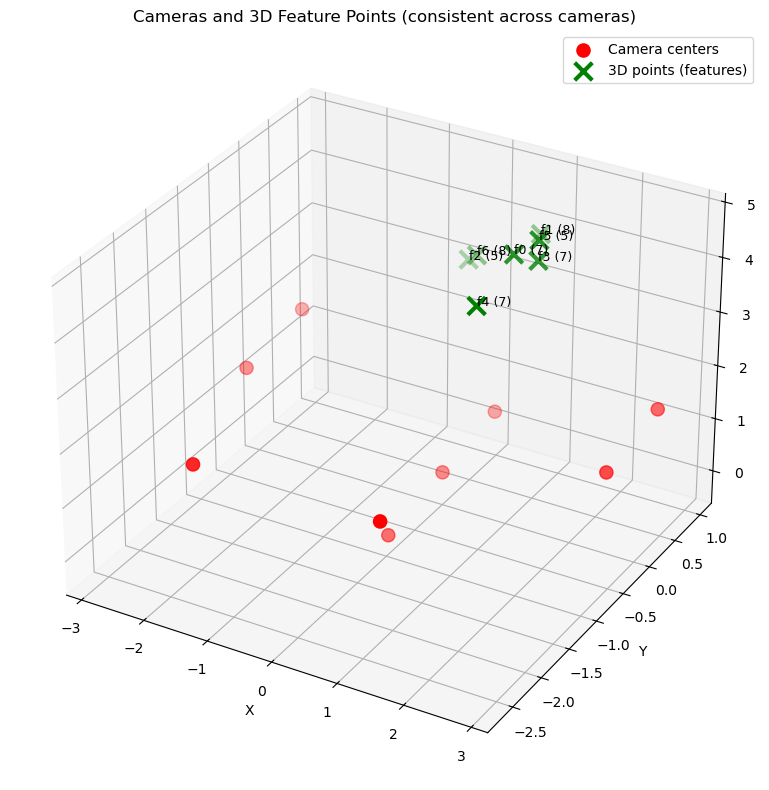

In [15]:
# ============================================================================
# STEP 4: Depth Map to 3D Points (CONSISTENT 7 FEATURES)
# - backproject each feature from every camera that sees it
# - aggregate (median) in world coordinates
# ============================================================================

import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt

def load_depth_01(depth_path, cam_idx):
    depth_file = os.path.join(depth_path, f'{cam_idx:02d}.png')
    d = cv.imread(depth_file, cv.IMREAD_UNCHANGED)
    if d is None:
        raise FileNotFoundError(f"Depth file not found: {depth_file}")
    return d.astype(np.float64) / 255.0

def safe_depth_sample(depth01, r, c, win=1):
    h, w = depth01.shape
    r = int(r); c = int(c)
    r0, r1 = max(0, r-win), min(h, r+win+1)
    c0, c1 = max(0, c-win), min(w, c+win+1)
    patch = depth01[r0:r1, c0:c1].reshape(-1)
    patch = patch[np.isfinite(patch)]
    patch = patch[patch > 0.01]
    if patch.size == 0:
        return None
    return float(np.median(patch))

def get_camera_centers(T_world_to_cam):
    centers = np.zeros((len(T_world_to_cam), 3), dtype=np.float64)
    for i in range(len(T_world_to_cam)):
        R = T_world_to_cam[i][:3, :3]
        t = T_world_to_cam[i][:3, 3]
        centers[i] = -R.T @ t
    return centers

def backproject_feature_to_world(pt_rc, depth01, scale, T_w2c, camera_calibration):
    """
    pt_rc = [row, col]
    depth01 in [0,1], scale from Step 3
    """
    fx = float(camera_calibration['focal_length_px'])
    fy = fx * float(camera_calibration['pixel_ratio'])
    cx = float(camera_calibration['principal_point'][1])
    cy = float(camera_calibration['principal_point'][0])

    r, c = int(round(pt_rc[0])), int(round(pt_rc[1]))
    d = safe_depth_sample(depth01, r, c, win=1)
    if d is None:
        return None

    Z = d * float(scale)
    if not np.isfinite(Z) or Z <= 0:
        return None

    X = (c - cx) * Z / fx
    Y = (r - cy) * Z / fy
    p_cam = np.array([X, Y, Z, 1.0], dtype=np.float64)

    T_c2w = np.linalg.inv(T_w2c)
    p_w = (T_c2w @ p_cam)[:3]
    return p_w

def reconstruct_features_world(given_features, depth_path, T_world_to_cam, depth_scales, camera_calibration):
    num_cams, num_feats, _ = given_features.shape
    depths01 = [load_depth_01(depth_path, i) for i in range(num_cams)]

    feat_world = np.full((num_feats, 3), np.nan, dtype=np.float64)
    feat_counts = np.zeros(num_feats, dtype=int)

    for f in range(num_feats):
        candidates = []
        for cam in range(num_cams):
            pt = given_features[cam, f]
            if pt[0] == -1:
                continue
            pw = backproject_feature_to_world(pt, depths01[cam], depth_scales[cam],
                                              T_world_to_cam[cam], camera_calibration)
            if pw is not None and np.isfinite(pw).all():
                candidates.append(pw)

        if len(candidates) > 0:
            candidates = np.vstack(candidates)
            feat_world[f] = np.median(candidates, axis=0)
            feat_counts[f] = candidates.shape[0]

    return feat_world, feat_counts

def plot_cameras_and_features(T_world_to_cam, feat_world, feat_counts):
    cam_centers = get_camera_centers(T_world_to_cam)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(cam_centers[:, 0], cam_centers[:, 1], cam_centers[:, 2],
               c="red", s=90, label="Camera centers")

    valid = np.isfinite(feat_world).all(axis=1)
    pts = feat_world[valid]
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
               c="green", marker="x", s=160, linewidths=3, label="3D points (features)")

    # label features
    for f in np.where(valid)[0]:
        p = feat_world[f]
        ax.text(p[0], p[1], p[2], f"f{f} ({feat_counts[f]})", fontsize=9)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Cameras and 3D Feature Points (consistent across cameras)")
    ax.legend()
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("STEP 4: Reconstruct 3D feature points (consistent)")
print("="*60)

feat_world, feat_counts = reconstruct_features_world(
    given_features, depth_path, T_world_to_cam, depth_scales, camera_calibration
)

print("\nFeature world points:")
for f in range(feat_world.shape[0]):
    if np.isfinite(feat_world[f]).all():
        print(f"  f{f}: {feat_world[f]}   (from {feat_counts[f]} cams)")
    else:
        print(f"  f{f}: INVALID")

plot_cameras_and_features(T_world_to_cam, feat_world, feat_counts)


Example visualization of cameras and 3D points (of the 7 features) from one image

![title](data/samples/features.png)

<h2 style="color:#007b90">Step 5: 3D Points to Point Cloud</h2>

Finally, use the provided `ply_creator` function to generate a merged colored point cloud from the computed 3D points from all images. Visualize the resulting point cloud in a viewer such as MeshLab.

In [16]:
# ============================================================================
# STEP 5: Create merged colored point cloud (PLY) from ALL images
# ============================================================================

import os
import numpy as np
import cv2 as cv

def build_K(camera_calibration):
    fx = float(camera_calibration['focal_length_px'])
    fy = fx * float(camera_calibration['pixel_ratio'])
    cx = float(camera_calibration['principal_point'][1])  # col
    cy = float(camera_calibration['principal_point'][0])  # row
    K = np.array([[fx, 0,  cx],
                  [0,  fy, cy],
                  [0,  0,  1]], dtype=np.float64)
    return K

def load_depth_01(depth_path, cam_idx):
    depth_file = os.path.join(depth_path, f'{cam_idx:02d}.png')
    d = cv.imread(depth_file, cv.IMREAD_UNCHANGED)
    if d is None:
        raise FileNotFoundError(f"Depth file not found: {depth_file}")
    return d.astype(np.float64) / 255.0

def backproject_depth_to_world_points(depth01, image_bgr, scale, T_w2c, camera_calibration,
                                      stride=4, min_depth01=0.01, max_points_per_cam=None):
    """
    depth01: (H,W) float in [0,1]
    image_bgr: (H,W,3) uint8
    scale: depth scale for this camera
    T_w2c: world->camera 4x4
    stride: subsampling step for pixels
    Returns:
      Xw: (N,3) world points
      rgb: (N,3) uint8 RGB colors
    """
    fx = float(camera_calibration['focal_length_px'])
    fy = fx * float(camera_calibration['pixel_ratio'])
    cx = float(camera_calibration['principal_point'][1])
    cy = float(camera_calibration['principal_point'][0])

    R = T_w2c[:3, :3]
    t = T_w2c[:3, 3]

    H, W = depth01.shape

    # pixel grid (subsampled)
    v = np.arange(0, H, stride, dtype=np.int32)  # rows
    u = np.arange(0, W, stride, dtype=np.int32)  # cols
    uu, vv = np.meshgrid(u, v)  # shapes: (Hv, Wu)

    d = depth01[vv, uu]
    valid = np.isfinite(d) & (d > min_depth01)

    uu = uu[valid].astype(np.float64)
    vv = vv[valid].astype(np.float64)
    d  = d[valid].astype(np.float64)

    if uu.size == 0:
        return np.zeros((0, 3), dtype=np.float64), np.zeros((0, 3), dtype=np.uint8)

    # scaled depth
    Z = d * float(scale)
    validZ = np.isfinite(Z) & (Z > 0)
    uu, vv, Z = uu[validZ], vv[validZ], Z[validZ]

    if uu.size == 0:
        return np.zeros((0, 3), dtype=np.float64), np.zeros((0, 3), dtype=np.uint8)

    # camera coordinates
    X = (uu - cx) * Z / fx
    Y = (vv - cy) * Z / fy
    Xc = np.stack([X, Y, Z], axis=0)  # (3,N)

    # world coordinates: Xw = R^T (Xc - t)
    Xw = (R.T @ (Xc - t.reshape(3, 1))).T  # (N,3)
## new version , remove to get old 

# colors
    rgb = image_bgr[vv.astype(np.int32),
                    uu.astype(np.int32), ::-1].astype(np.uint8)

# ---------- WORLD-SPACE CROP (CRITICAL FIX) ----------
    Cw = (-R.T @ t).reshape(1, 3)   # correct camera center in world
    dist = np.linalg.norm(Xw - Cw, axis=1)

    max_radius = 3.5
    keep = dist < max_radius

    Xw = Xw[keep]
    rgb = rgb[keep]
# ----------------------------------------------------

    # colors (from image at same pixels)
    # image_bgr[v,u] -> BGR; convert to RGB for ply_creator
    rgb = image_bgr[vv.astype(np.int32), uu.astype(np.int32), ::-1].astype(np.uint8)

    # Optional: cap number of points per cam (random sample)
    if max_points_per_cam is not None and Xw.shape[0] > max_points_per_cam:
        idx = np.random.choice(Xw.shape[0], size=max_points_per_cam, replace=False)
        Xw = Xw[idx]
        rgb = rgb[idx]

    return Xw, rgb


print("\n" + "="*60)
print("STEP 5: Export merged colored point cloud (PLY)")
print("="*60)

num_cams = len(undistorted_images)

# Load all depth maps
depths01 = [load_depth_01(depth_path, i) for i in range(num_cams)]

all_points = []
all_colors = []

# Controls: increase stride to reduce size (4 or 6 is reasonable)
stride = 4
max_points_per_cam = None  # e.g., 200000 to cap per camera

for cam_idx in range(num_cams):
    Xw, rgb = backproject_depth_to_world_points(
        depth01=depths01[cam_idx],
        image_bgr=undistorted_images[cam_idx],
        scale=depth_scales[cam_idx],
        T_w2c=T_world_to_cam[cam_idx],
        camera_calibration=camera_calibration,
        stride=stride,
        min_depth01=0.01,
        max_points_per_cam=max_points_per_cam
    )
    print(f"Camera {cam_idx}: added {Xw.shape[0]} points")
    all_points.append(Xw)
    all_colors.append(rgb)

all_points = np.vstack(all_points) if len(all_points) else np.zeros((0, 3), dtype=np.float64)
all_colors = np.vstack(all_colors) if len(all_colors) else np.zeros((0, 3), dtype=np.uint8)

print(f"\nTotal merged points: {all_points.shape[0]}")

# Save PLY (write into /mnt/data so you can download easily)
ply_base = "output/point_cloud/pointcloud_3.2"
ply_file = ply_creator(all_points, all_colors, filename=ply_base)

print(f"\nSaved merged point cloud to: {ply_file}")
print("Open this .ply in MeshLab to visualize.")



STEP 5: Export merged colored point cloud (PLY)
Camera 0: added 30498 points
Camera 1: added 1139 points
Camera 2: added 10686 points
Camera 3: added 5601 points
Camera 4: added 4787 points
Camera 5: added 12945 points
Camera 6: added 57 points
Camera 7: added 30498 points
Camera 8: added 11184 points

Total merged points: 107395

Saved merged point cloud to: output/point_cloud/pointcloud_3.2.ply
Open this .ply in MeshLab to visualize.


Example visualization

![title](data/samples/dense_point_cloud.png)

In [17]:
for i in range(2):
    d = cv.imread(os.path.join(depth_path, f"{i:02d}.png"), cv.IMREAD_UNCHANGED)
    print(i, d.dtype, d.min(), d.max())
print("depth_scales:", depth_scales)


0 uint8 110 255
1 uint8 112 255
depth_scales: [1.         6.03374274 5.80075595 5.68835422 6.14469068 5.08578652
 6.11179759 1.         5.13743701]
